<h1><center>Basics of Algorithmic Trading</center></h1>

# Linear Regression for Market Price, Returns and Movement Prediction

Linear regression is a linear approach to modelling the relationship between a scalar response and one or more explanatory variables. The relationships are modelled using a linear predictor function whose parameters are estimated from the data.

# Setup

In [1]:
import numpy as np

import pandas as pd

from sklearn import linear_model
from sklearn. metrics import accuracy_score

import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns
sns.set_theme(style="darkgrid")

# Read the data from local drive

In [2]:
data = pd.HDFStore('data/BitcoinPriceData.h5', 'r')

dataLR = data['BitcoinPriceData']

data.close()

print(dataLR.info())
print('-'*20)
print('-'*20)
print(dataLR.tail())

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1980 entries, 2016-01-01 to 2021-06-02
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Value   1980 non-null   float64
dtypes: float64(1)
memory usage: 30.9 KB
None
--------------------
--------------------
               Value
Date                
2021-05-29  35689.62
2021-05-30  34647.67
2021-05-31  35684.59
2021-06-01  37310.54
2021-06-02  36662.64


In [3]:
dataLR.rename(columns={'Value':'price'}, inplace=True)

# Ordinary Least Squares Regression (OLS)

In [4]:
# Returns (log scale).
dataLR['returns'] = np.log(dataLR['price'] / dataLR['price'].shift(1))

dataLR.dropna(inplace=True)

In [5]:
# Last 'lags' days price (US$) and returns (log scale).
lags = 3

# Price.
cols_price = [] 
for lag in range(1, lags + 1): 
  col = f'lag_{lag}_price' 
  dataLR[col] = dataLR['price'].shift(lag) 
  cols_price.append(col)


# Returns.
cols_return = [] 
for lag in range(1, lags + 1): 
  col = f'lag_{lag}_return' 
  dataLR[col] = dataLR['returns'].shift(lag) 
  cols_return.append(col)

dataLR.dropna(inplace=True)

dataLR.head()

,price,returns,lag_1_price,lag_2_price,lag_3_price,lag_1_return,lag_2_return,lag_3_return
Date,,,,,,,,
2016-01-05,431.90,-0.002544,433.00,432.76,433.94,0.000554,-0.002723,0.003717
2016-01-06,432.43,0.001226,431.90,433.00,432.76,-0.002544,0.000554,-0.002723
2016-01-07,453.71,0.048038,432.43,431.90,433.00,0.001226,-0.002544,0.000554
2016-01-08,447.04,-0.014810,453.71,432.43,431.90,0.048038,0.001226,-0.002544
2016-01-09,452.64,0.012449,447.04,453.71,432.43,-0.014810,0.048038,0.001226


In [6]:
dataLR.tail()

,price,returns,lag_1_price,lag_2_price,lag_3_price,lag_1_return,lag_2_return,lag_3_return
Date,,,,,,,,
2021-05-29,35689.62,-0.074376,38445.29,39266.04,38410.50,-0.021124,0.022029,-0.008247
2021-05-30,34647.67,-0.029629,35689.62,38445.29,39266.04,-0.074376,-0.021124,0.022029
2021-05-31,35684.59,0.029488,34647.67,35689.62,38445.29,-0.029629,-0.074376,-0.021124
2021-06-01,37310.54,0.044557,35684.59,34647.67,35689.62,0.029488,-0.029629,-0.074376
2021-06-02,36662.64,-0.017518,37310.54,35684.59,34647.67,0.044557,0.029488,-0.029629


In [7]:
# Divide the dataset into training and test dataset.
cutoff = '2021-04-01'

# Training data.
training_data = dataLR[dataLR.index < cutoff].copy()

# Test data.
test_data = dataLR[dataLR.index >= cutoff].copy()

## Predicting Future Price

In [8]:
# Fit a linear model.
reg_price = np.linalg.lstsq(training_data[cols_price] , training_data['price'] , rcond=None)[0]

reg_price

array([ 0.9802205 ,  0.04985572, -0.02526241])

The optimal regression parameters illustrate what is typically called the random walk hypothesis. This hypothesis states that stock prices or exchange rates, for example, follow a random walk with the consequence that the best predictor for tomorrow’s price is today’s price.

In [9]:
# Predicted price.
test_data['prediction_price'] = np.dot(test_data[cols_price], reg_price)

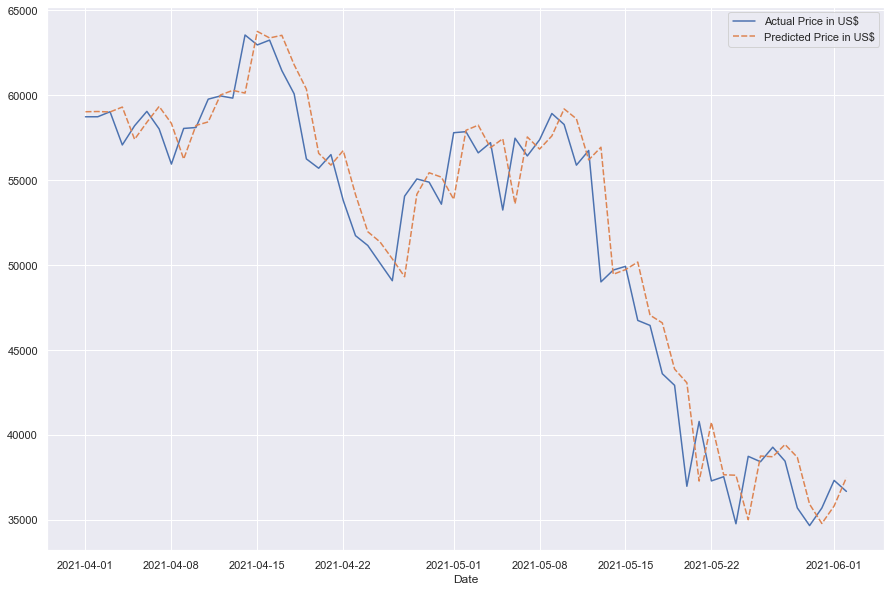

In [10]:
# Plot of actual price and predicted price over time (US$).
plt.figure(figsize=(15, 10))
ax = sns.lineplot(data=test_data[['price', 'prediction_price']], legend=False)
ax.legend(['Actual Price in US$', 'Predicted Price in US$'])
plt.show()

## Predicting Future Returns

In [11]:
# Fit a linear model.
reg_ret = np.linalg.lstsq(training_data[cols_return] , training_data['returns'] , rcond=None)[0]

reg_ret

array([-0.01702103,  0.03063005, -0.0130142 ])

In [12]:
# Predicted returns.
test_data['prediction_returns'] = np.dot(test_data[cols_return], reg_ret)

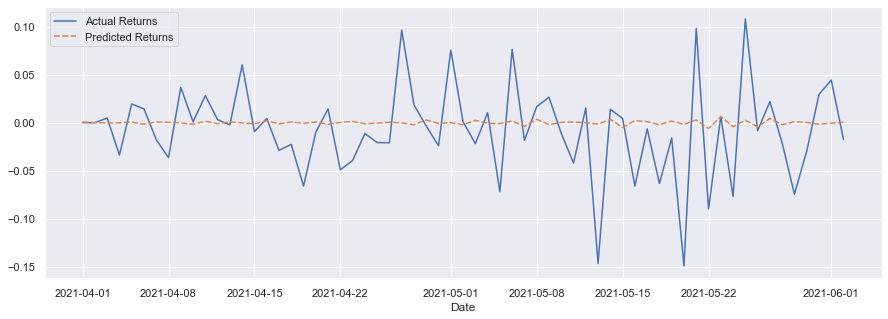

In [13]:
# Plot of actual returns and predicted returns over time (log scale).
plt.figure(figsize=(15, 5))
ax = sns.lineplot(data=test_data[['returns', 'prediction_returns']], legend=False)
ax.legend(['Actual Returns', 'Predicted Returns'])
plt.show()

From a trading point of view, one might argue that it is not the magnitude of the forecasted return that is relevant, but rather whether the direction is forecasted correctly or not. Whenever the linear regression gets the direction right, meaning that the sign of the forecasted return is correct, the product of the market return and the predicted return is positive and otherwise negative.

In [14]:
hits_returns = np.sign(test_data['returns'] * test_data['prediction_returns']).value_counts()

# Hit ratio.
hits_returns.values[0] / sum(hits_returns)

0.5238095238095238

The hit ratio of a prediction-based strategy is only one side of the coin. The other side is how well the strategy gets the market timing right. A strategy correctly predicting the best and worst days over a certain period might outperform the market even with a hit ratio below 50%. On the other hand, a strategy with a hit ratio well above 50% might still underperform the base instrument if it gets the rare, large movements wrong.

## Predicting Future Market Direction

In [15]:
# Fit a linear model.
reg_dr = np.linalg.lstsq(training_data[cols_return], np.sign(training_data['returns']), rcond=None)[0]

reg_dr

array([-0.87735919,  0.72759109,  0.23054606])

In [16]:
# Predicted direction.
test_data['prediction_direcn'] = np.sign(np.dot(test_data[cols_return], reg_dr))

In [17]:
hits_dr = np.sign(test_data['returns'] * test_data['prediction_direcn']).value_counts()

# Hit ratio.
hits_dr.values[0] / sum(hits_dr)

0.5873015873015873

In [18]:
# Strategy based returns (log scale).
test_data['strategy'] = test_data['prediction_direcn'] * test_data['returns']

In [19]:
# Final returns based on the passive benchmark investment and strategy (regular scale).
returns = test_data[['returns', 'strategy']].sum().apply(np.exp)

returns

returns     0.624256
strategy    2.960897
dtype: float64

In [20]:
# Cumulative returns over time based on the passive benchmark investment and strategy (regular scale).
gross_performance_lr = test_data[['returns', 'strategy']].cumsum().apply(np.exp)

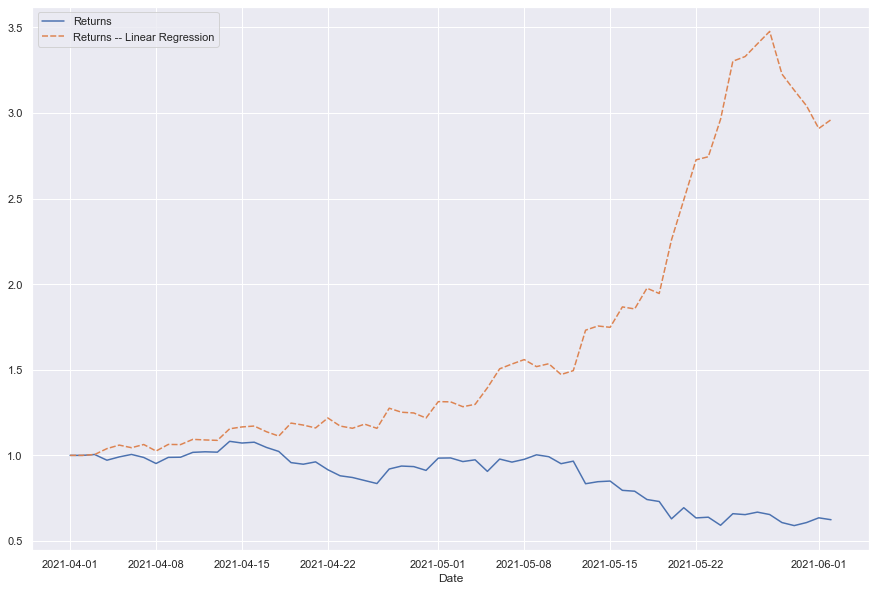

In [21]:
# Plot of cumulative returns based on the passive benchmark investment and strategy over time (regular scale).
plt.figure(figsize=(15, 10))
ax = sns.lineplot(data=gross_performance_lr, legend=False)
ax.legend(['Returns', 'Returns -- Linear Regression'])
plt.show()

In [22]:
# Trades executed.
trades_lr = test_data['prediction_direcn'].diff().fillna(0) != 0

trades_lr.tail()

Date
2021-05-29     True
2021-05-30    False
2021-05-31     True
2021-06-01    False
2021-06-02    False
Name: prediction_direcn, dtype: bool

In [23]:
# Amount invested (US$).
amount_lr = 10000
# Transaction cost (constant) (log scale).
transaction_cost_lr = 0.1/100

# Subtract the transaction cost.
test_data['strategy'][trades_lr] -= transaction_cost_lr 

# Cumulative returns (US$).
test_data['creturns'] = amount_lr * test_data['returns'].cumsum().apply(np.exp)
test_data['cstrategy'] = amount_lr * test_data['strategy'].cumsum().apply(np.exp)

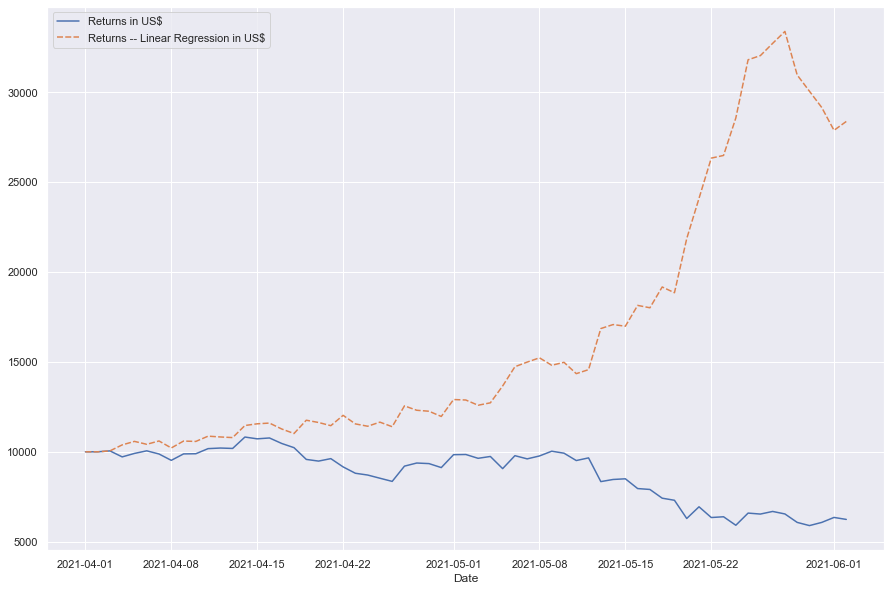

In [24]:
# Plot of cumulative returns.
plt.figure(figsize=(15, 10))
ax = sns.lineplot(data=test_data[['creturns', 'cstrategy']], legend=False)
ax.legend(['Returns in US$', 'Returns -- Linear Regression in US$'])
plt.show()

### References

N/A